# 01. Preliminary

Reviewing & previewing some basic linear algebras that are implemented in well-known algorithms and how they are implemented.

In [1]:
import sys
sys.path.append("../")

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nl
import scipy
from sklearn.datasets import fetch_lfw_people

import linalg

In [12]:
A = np.array(([1, 2, 3], [4, 5, 6]))
B = A.T
C = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

## 01. SVD

### `numpy.linalg.svd`

- Finding a approximate eignevectors 
- [API Reference](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)
- Factorized as $A=USV^T$
    - If True (default), U and Vh are of shape (M, M), (N, N). If False, the shapes are (M, K) and (K, N), where K = min(M, N).
    - Normally, $K$ is rank of $A$.

In [75]:
u, s, vh = nl.svd(
    a=A,
    full_matrices=False, # Return 
    compute_uv=True,
    hermitian=False, # Assume a is a Hermitian (symmetric). Uses more efficient method
)

# Shape of decomposed result
print(u.shape, s.shape, vh.shape)
print(u, s, vh)

A, u @ (s * np.identity(n=s.size)) @ vh

(2, 2) (2,) (2, 3)
[[-0.3863177  -0.92236578]
 [-0.92236578  0.3863177 ]] [9.508032   0.77286964] [[-0.42866713 -0.56630692 -0.7039467 ]
 [ 0.80596391  0.11238241 -0.58119908]]


(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[1., 2., 3.],
        [4., 5., 6.]]))

In [76]:
# Order of singular values does not matter
A, u[:, ::-1] @ (s * np.identity(n=s.size))[::-1, ::-1] @ vh[::-1, :]

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[1., 2., 3.],
        [4., 5., 6.]]))

In [63]:
u, s, vh = nl.svd(
    a=A,
    full_matrices=True, # Return 
    compute_uv=True,
    hermitian=False, # Assume a is a Hermitian (symmetric). Uses more efficient method
)

# Shape of decomposed result
print(u.shape, s.shape, vh.shape)
print(u, s, vh)

(2, 2) (2,) (3, 3)
[[-0.3863177  -0.92236578]
 [-0.92236578  0.3863177 ]] [9.508032   0.77286964] [[-0.42866713 -0.56630692 -0.7039467 ]
 [ 0.80596391  0.11238241 -0.58119908]
 [ 0.40824829 -0.81649658  0.40824829]]


- $U$ and $V$ are called left/right eigenvectors
- They can be obtained by calculating eigenvectors for $A^TA$ and $AA^T$
    - $A^TA=(USV^T)^T \times (USV^T) = VS^TU^T \times USV^T = VS^2V^T$
    - $AA^T=(USV^T) \times (USV^T)^T = USV^T \times VS^TU^T = US^2U^T$

Let's check if they are true. Note that directions of eigenvectors may be opposite

#### Find Left Eigenvectors

In [98]:
w, u_ = nl.eigh(A @ A.T) # Returns eigenvalue, eigenvector for hermitian matrix

In [99]:
# Check eigenvalues
w = np.sqrt(w)
s.sort()
w, s

(array([0.77286964, 9.508032  ]), array([0.77286964, 9.508032  ]))

In [100]:
# Eigenvalue sorting
idx = (-w).argsort()
u_[idx], u

(array([[ 0.3863177 ,  0.92236578],
        [-0.92236578,  0.3863177 ]]),
 array([[-0.3863177 , -0.92236578],
        [-0.92236578,  0.3863177 ]]))

#### Find Right Eigenvectors

In [101]:
w, v = nl.eigh(A.T @ A) # Returns eigenvalue, eigenvector for hermitian matrix

In [59]:
idx = (-w).argsort()
v.T[idx], vh

(array([[-0.42866713, -0.56630692, -0.7039467 ],
        [-0.80596391, -0.11238241,  0.58119908],
        [ 0.40824829, -0.81649658,  0.40824829]]),
 array([[-0.42866713, -0.56630692, -0.7039467 ],
        [ 0.80596391,  0.11238241, -0.58119908],
        [ 0.40824829, -0.81649658,  0.40824829]]))

## 02. PCA

Self-implemented PCA
1. Get centered data (image)
2. Find covariance matrix of a centered images
3. Find left singular vector of centered images OR get top-k eigenvectors of covariance matrix
4. Transform with left singular eigenvectors


#### 02-0. Get Images

In [110]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
lfw_people["data"].shape, lfw_people["images"][0].shape

((1288, 1850), (50, 37))

In [118]:
num_data = lfw_people["data"].shape[0]
H, W = lfw_people["images"][0].shape
num_feats = lfw_people["data"].shape[1]
assert num_feats == H * W

In [ ]:
def plot_face(arr: np.ndarray, cmap="gray", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=())

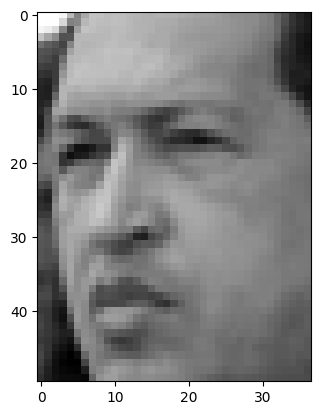

In [126]:
plt.imshow(lfw_people["images"][0], cmap="gray");

#### 02-1. Get Centered data

In [281]:
X = lfw_people["data"] # (num_data, num_feats)
mu = X.mean(axis=0) # (num_feats,)
assert mu.size == num_feats

Y = X - mu # (num_data, num_feats), centered

#### 02-2-1. With Covariance Matrix
- Use Eigenvectors of covariance matrix. Choose top-k

In [343]:
top_k = 200

In [344]:
cov = (Y @ Y.T) / num_data
w, v = nl.eigh(a=cov)

In [353]:
eig = v[(-np.abs(w)).argsort(), :top_k]
eig.shape

(1288, 200)

In [354]:
beta = eig.T @ Y # (top_k, num_feats)

In [355]:
recon = ((eig @ beta)).reshape(-1, H, W)

In [356]:
eigen_faces = beta.reshape(-1, H, W)

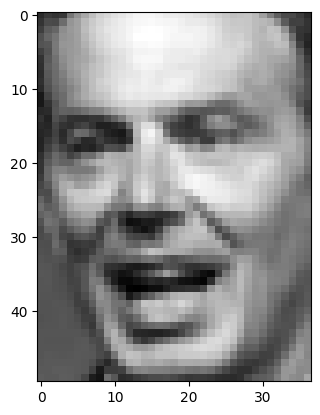

In [360]:
plt.imshow(X[1].reshape(H, W), cmap="gray")

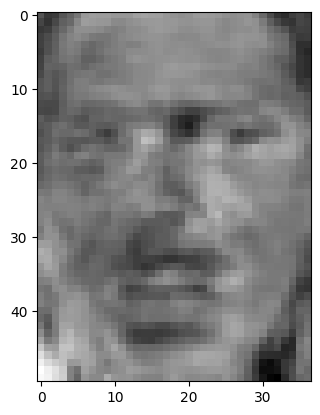

In [359]:
plt.imshow(recon[1], cmap="gray")

#### 02-2-1. With Centered data
- Use Left-singular vector

In [318]:
u, s, vh = nl.svd(a=Y, full_matrices=False)
u.shape, s.shape, vh.shape

u, vh = svd_flip(u, vh)

In [249]:
top_k = 1200
ls = u[:, :top_k]

In [276]:
ls = u[(-w).argsort(), :top_k]

#### 02-4. Get low-dimensional Fetaure vectors

- Original data: (num_data, num_feats)
- Minimized data:
    - Low-dimensional features: (num_data, top_k)
    - Recon vectors (top-k orthonormal eigenvectors from left-singular): (num_feats, top_k)

In [274]:
from linalg.utils import svd_flip

In [277]:
beta = (ls.T @ Y) # (top_k, num_data)

In [278]:
(ls @ beta).shape

(1850, 1288)

In [279]:
recon = ((ls @ beta) + mu).reshape(-1, H, W)

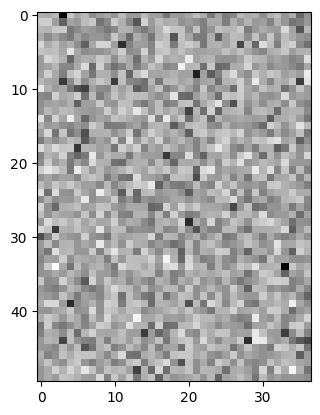

In [280]:
plt.imshow(recon[10], cmap="gray");